# synpuf disclosure risk

Compare synthetic PUFs trained from a 50% sample, both to the training set and the remaining 50% holdout. Synthetic file (1) is from synthimpute random forests; (2) is from the synthpop R package.

## Setup

### Imports

In [1]:
import pandas as pd
import numpy as np
import synthimpute as si
from scipy import stats

import matplotlib as mpl
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.ticker import ScalarFormatter

**UPDATE!**

In [2]:
# ID from filename (synpufx.csv and nearestx.csv), and name for plots.
ID1 = 9
NAME1 = 'RF 20 trees'

ID2 = 10
NAME2 = 'RF 50 trees'

PUF_SAMPLE_DIR = '~/Downloads/puf/'
SYN_DIR = '~/Downloads/syntheses/'
NEAREST_DIR = '~/Downloads/nearest/'

### Graphing

In [3]:
# !wget https://github.com/MaxGhenis/random/raw/master/Roboto-Regular.ttf -P /usr/local/lib/python3.6/dist-packages/matplotlib/mpl-data/fonts/ttf
# mpl.font_manager._rebuild()

In [4]:
sns.set_style('white')
DPI = 200
mpl.rc('savefig', dpi=DPI)
mpl.rcParams['figure.dpi'] = DPI
mpl.rcParams['figure.figsize'] = 6.4, 4.8  # Default.
mpl.rcParams['font.sans-serif'] = 'Roboto'
mpl.rcParams['font.family'] = 'sans-serif'

# Set title text color to dark gray (https://material.io/color) not black.
TITLE_COLOR = '#212121'
mpl.rcParams['text.color'] = TITLE_COLOR

# Axis titles and tick marks are medium gray.
AXIS_COLOR = '#757575'
mpl.rcParams['axes.labelcolor'] = AXIS_COLOR
mpl.rcParams['xtick.color'] = AXIS_COLOR
mpl.rcParams['ytick.color'] = AXIS_COLOR

### Load data

In [5]:
synth1 = pd.read_csv(SYN_DIR + 'synpuf' + str(ID1) + '.csv').drop('S006', axis=1)
synth2 = pd.read_csv(SYN_DIR + 'synpuf' + str(ID2) + '.csv').drop('S006', axis=1)
train = pd.read_csv(PUF_SAMPLE_DIR + 'train50.csv').drop('S006', axis=1)
test = pd.read_csv(PUF_SAMPLE_DIR + 'test50.csv').drop('S006', axis=1)
nearest1 = pd.read_csv(NEAREST_DIR + 'nearest' + str(ID1) + '.csv')
nearest2 = pd.read_csv(NEAREST_DIR + 'nearest' + str(ID2) + '.csv')

## Examine results

In [6]:
print(NAME1)
nearest1.sort_values('train_dist').head()

RF 20 trees


,synth_id,train_id,train_dist,test_id,test_dist,dist_diff,dist_ratio
9863,9863,50716,0.0,43362,0.026880,-0.026880,0.0
51319,51319,7188,0.0,37693,0.027098,-0.027098,0.0
42046,42046,25968,0.0,60376,0.328963,-0.328963,0.0
44057,44057,64330,0.0,43304,0.151908,-0.151908,0.0
28130,28130,37727,0.0,55556,0.106375,-0.106375,0.0


In [7]:
print(NAME2)
nearest2.sort_values('dist_diff').head()

RF 50 trees


,synth_id,train_id,train_dist,test_id,test_dist,dist_diff,dist_ratio
24967,24967,26147,7.791914,31682,217.893967,-210.102054,0.035760
73237,73237,18411,6.936005,69958,132.534926,-125.598921,0.052333
22391,22391,73426,7.344517,43893,49.711963,-42.367446,0.147741
38597,38597,3291,8.914421,43893,49.929579,-41.015158,0.178540
19294,19294,6389,10.305378,76304,49.135383,-38.830005,0.209734


In [8]:
print(NAME2)
nearest2.sort_values('train_dist').head()

RF 50 trees


,synth_id,train_id,train_dist,test_id,test_dist,dist_diff,dist_ratio
13241,13241,24181,0.0,28381,0.054929,-0.054929,0.0
20320,20320,10393,0.0,42656,0.000000,0.000000,NaN
31007,31007,52626,0.0,81422,2.582099,-2.582099,0.0
51926,51926,15557,0.0,64101,0.103196,-0.103196,0.0
44681,44681,2299,0.0,49899,0.029919,-0.029919,0.0


## Analysis

In [9]:
print(NAME1)
nearest1[['train_dist', 'test_dist', 'dist_diff']].describe()

RF 20 trees


,train_dist,test_dist,dist_diff
count,81893.000000,81893.000000,81893.000000
mean,1.257246,1.357674,-0.100429
std,2.693091,3.326489,1.549427
min,0.000000,0.000000,-216.470848
25%,0.089908,0.126128,-0.112158
50%,0.464502,0.520004,-0.001508
75%,1.432195,1.509219,0.027175
max,110.401778,218.962351,22.247326


In [10]:
print(NAME2)
nearest2[['train_dist', 'test_dist', 'dist_diff']].describe()

RF 50 trees


,train_dist,test_dist,dist_diff
count,81893.000000,81893.000000,81893.000000
mean,1.483716,1.609399,-0.125684
std,2.731467,3.148190,1.226874
min,0.000000,0.000000,-210.102054
25%,0.182183,0.237417,-0.169173
50%,0.679038,0.818037,-0.002063
75%,1.789106,1.900322,0.031891
max,106.899054,217.893967,32.374413


In [11]:
stats.ttest_1samp(nearest1.dist_diff, 0)

Ttest_1sampResult(statistic=-18.54859542491342, pvalue=1.2027928736895796e-76)

In [12]:
stats.ttest_1samp(nearest2.dist_diff, 0)

Ttest_1sampResult(statistic=-29.31580993118519, pvalue=6.152865070020633e-188)

## Charts

### Scatterplots of distance to train and to test

Note we can't use log scales because of the exact zeros.

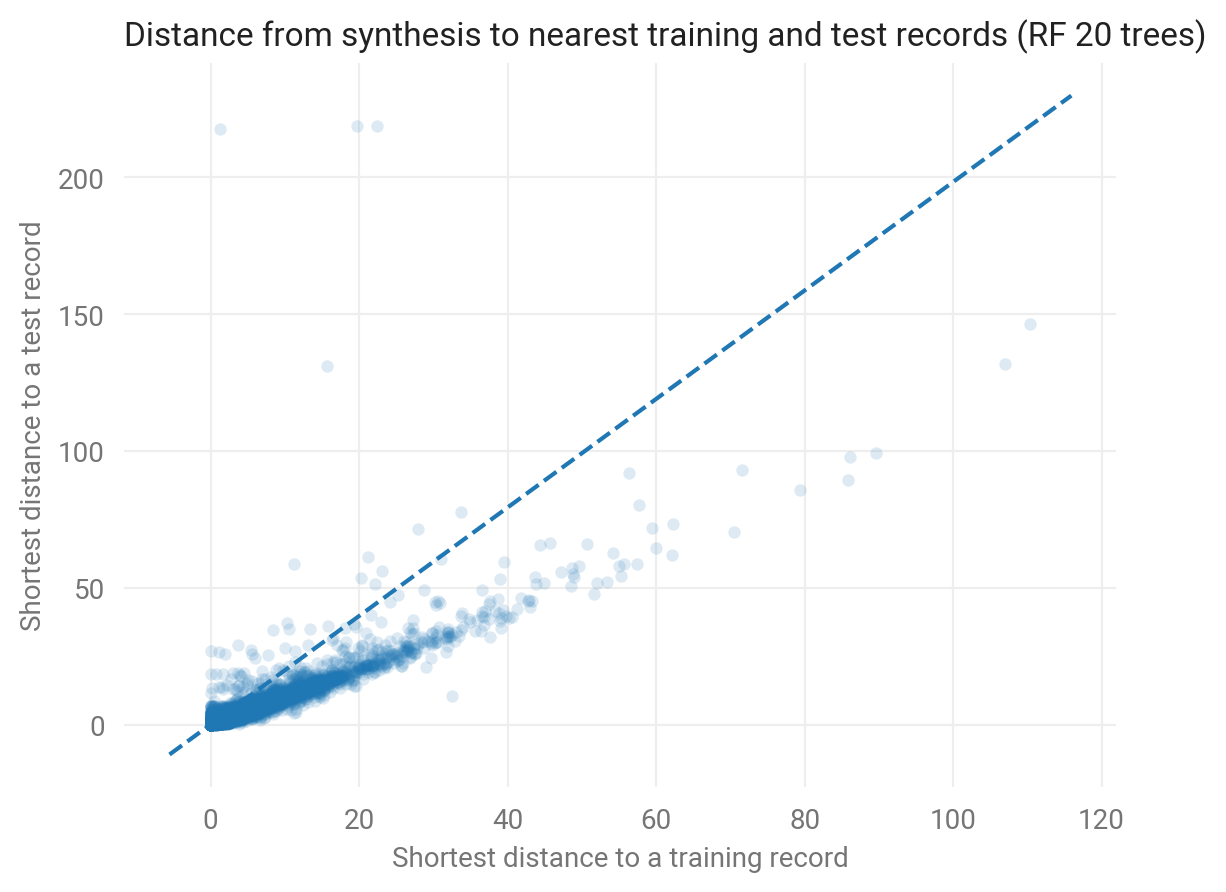

In [13]:
ax = nearest1.plot.scatter('train_dist', 'test_dist', alpha=0.15, linewidths=0.0)
# 45-degree line.
ax.plot(ax.get_xlim(), ax.get_ylim(), ls='--')
sns.despine(left=True, bottom=True)
ax.grid(color='#eeeeee')
for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_formatter(ScalarFormatter())
ax.set(xlabel='Shortest distance to a training record',
       ylabel='Shortest distance to a test record')
plt.title('Distance from synthesis to nearest training and test records (' + NAME1 + ')',
          loc='left')
plt.show()

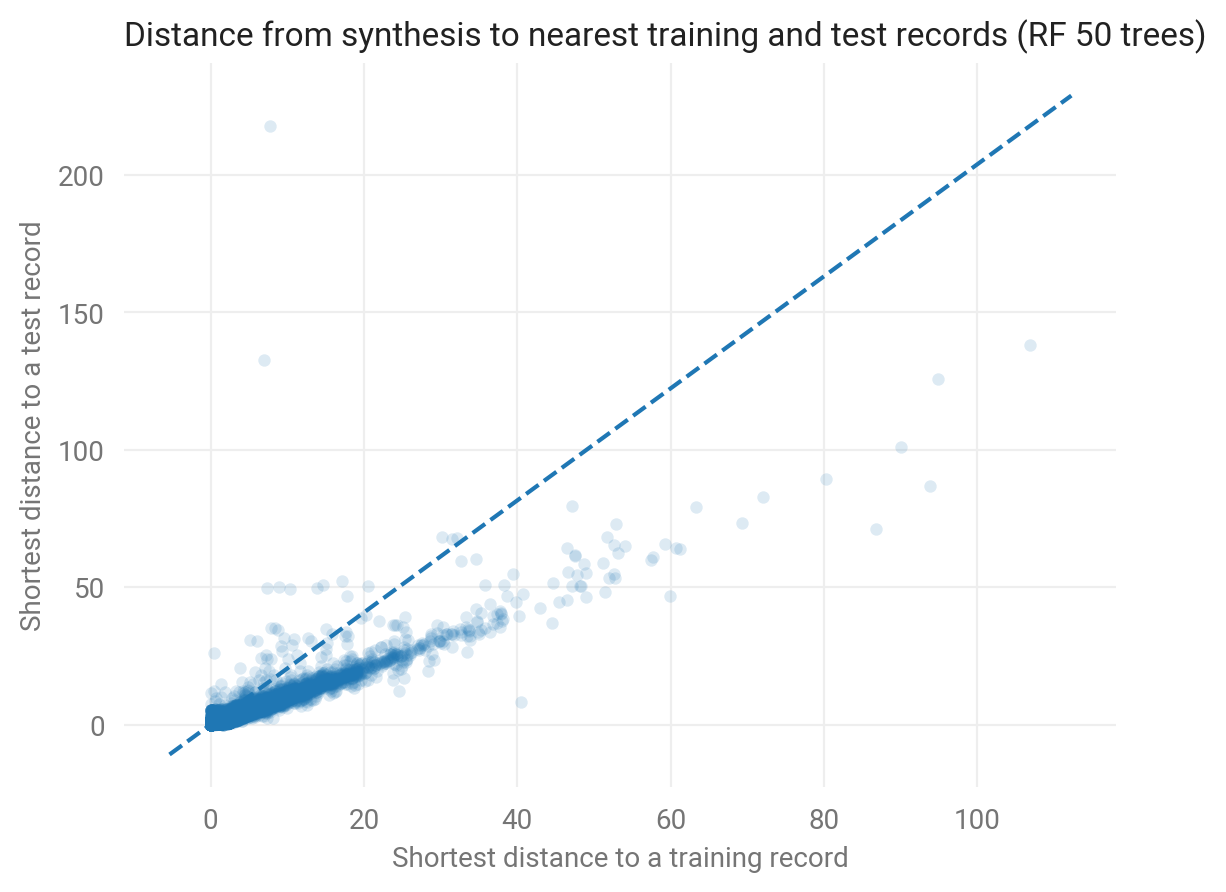

In [14]:
ax = nearest2.plot.scatter('train_dist', 'test_dist', alpha=0.15, linewidths=0.0)
# 45-degree line.
ax.plot(ax.get_xlim(), ax.get_ylim(), ls='--')
sns.despine(left=True, bottom=True)
ax.grid(color='#eeeeee')
for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_formatter(ScalarFormatter())
ax.set(xlabel='Shortest distance to a training record',
       ylabel='Shortest distance to a test record')
plt.title('Distance from synthesis to nearest training and test records (' + NAME2 + ')',
          loc='left')
plt.show()

### Boxplot of distances

In [15]:
distances_stacked = pd.DataFrame({
    'type': 'train',
    'model': NAME1,
    'dist': nearest1.train_dist
}).append(pd.DataFrame({
    'type': 'test',
    'model': NAME1,
    'dist': nearest1.test_dist
})).append(pd.DataFrame({
    'type': 'train',
    'model': NAME2,
    'dist': nearest2.train_dist
})).append(pd.DataFrame({
    'type': 'test',
    'model': NAME2,
    'dist': nearest2.test_dist
}))

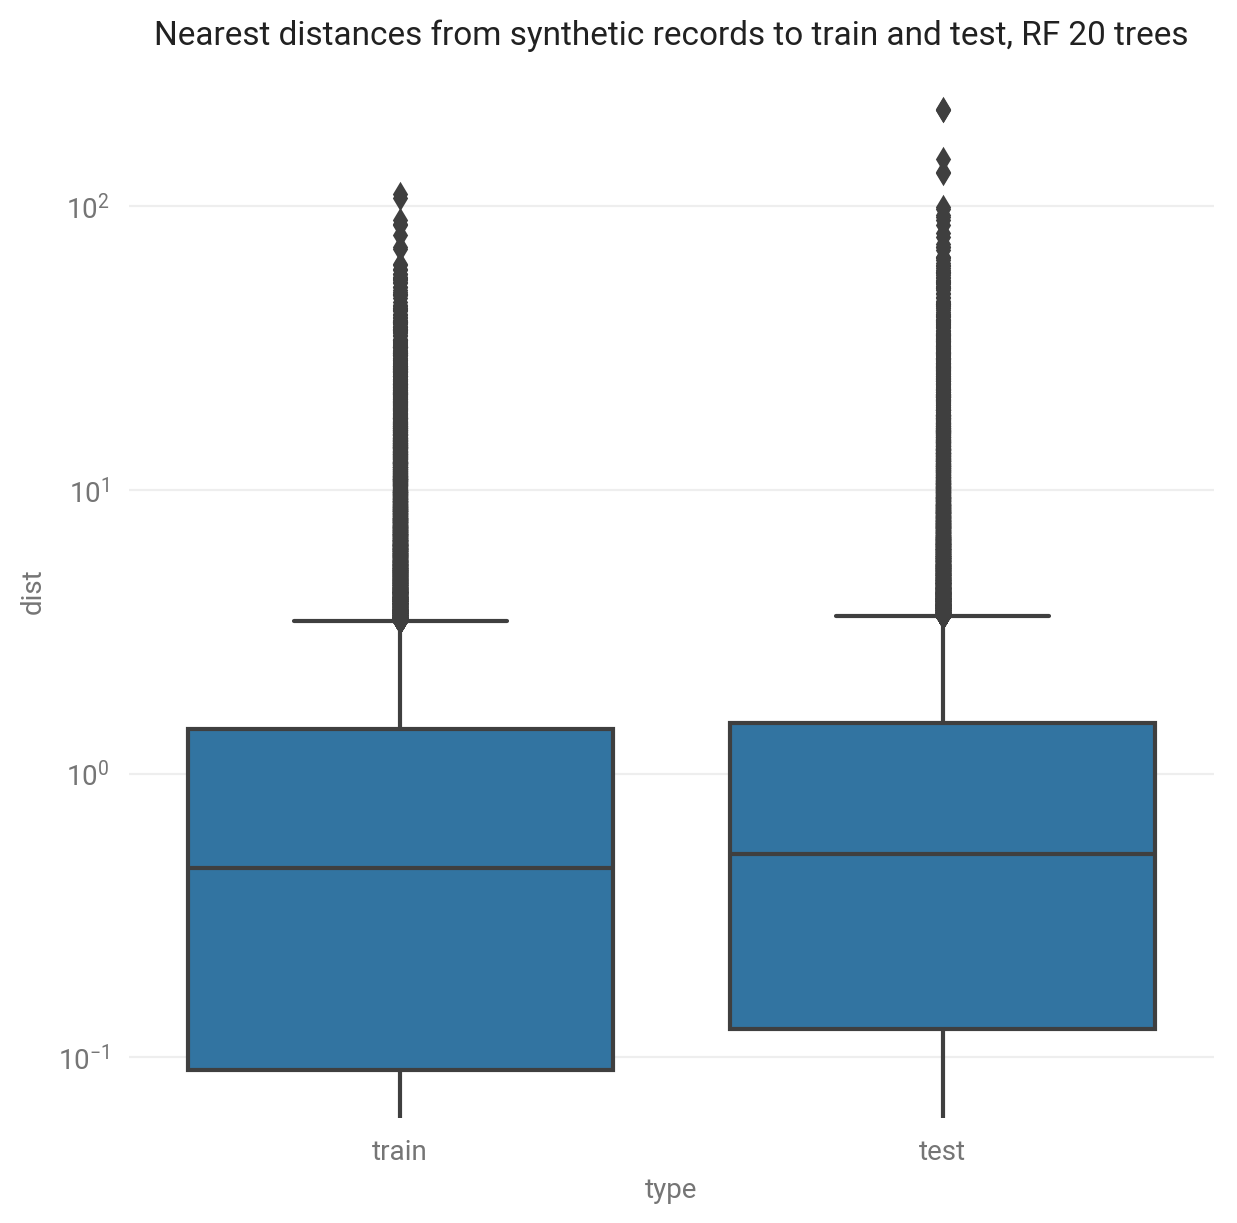

In [16]:
f, ax = plt.subplots(figsize=(7, 7))
ax.set(yscale='log')
sns.boxplot(x='type', y='dist', hue='model',
            data=distances_stacked[distances_stacked.model == NAME1])
sns.despine(left=True, bottom=True)
ax.yaxis.grid(color='#eeeeee')
plt.title('Nearest distances from synthetic records to train and test, ' + NAME1)
ax.get_legend().remove()
plt.show()

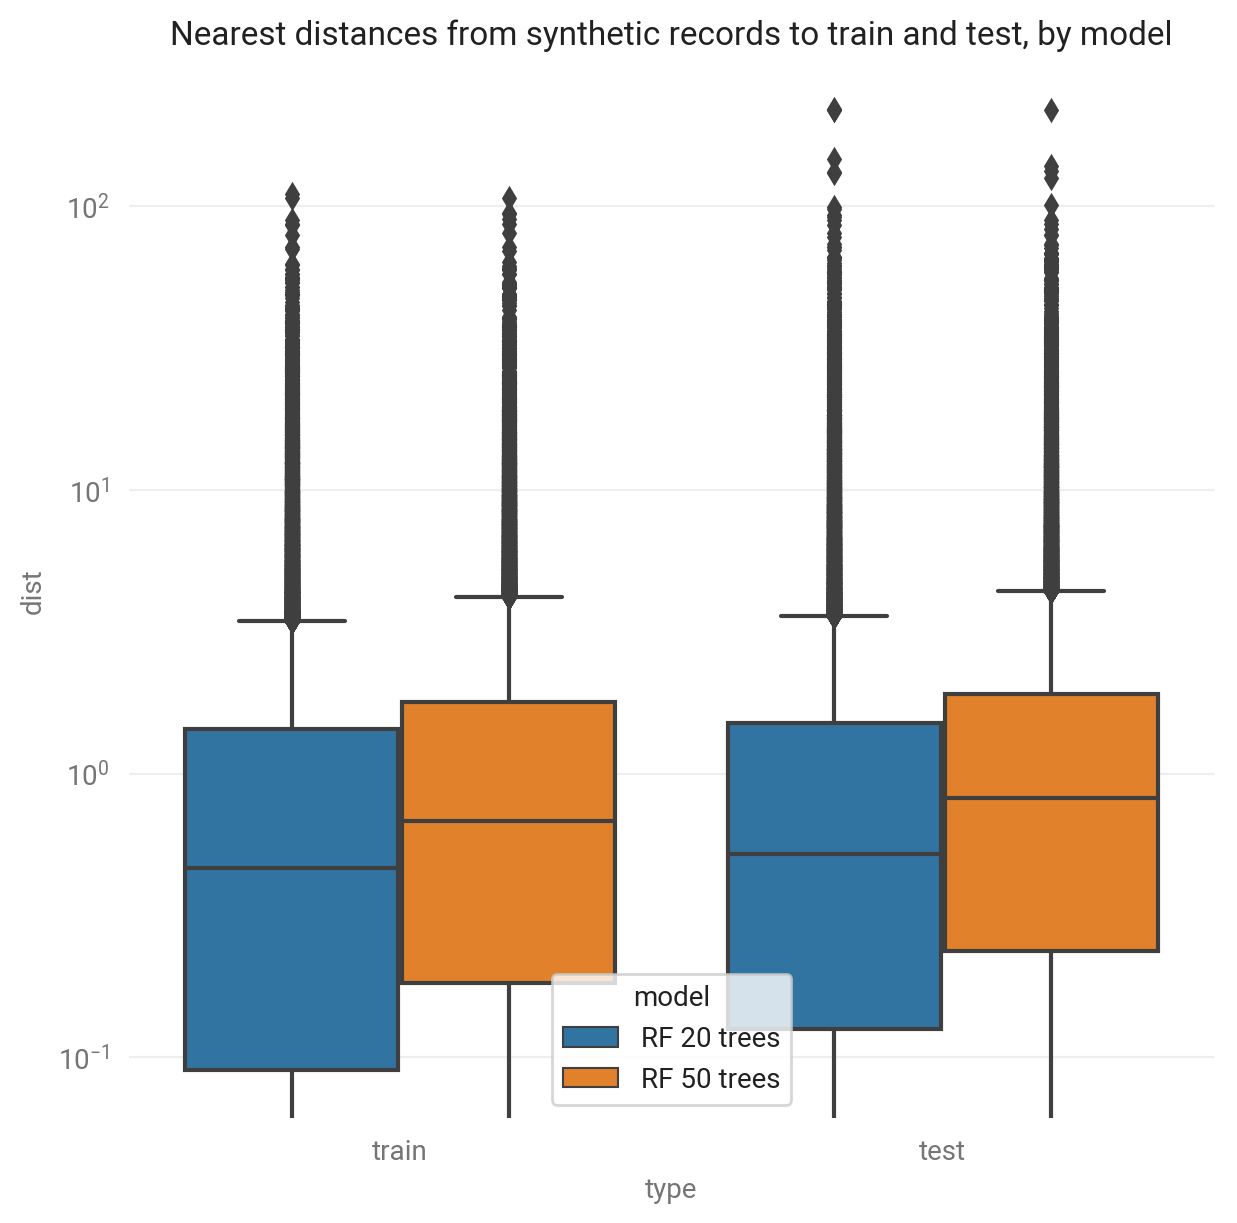

In [17]:
f, ax = plt.subplots(figsize=(7, 7))
ax.set(yscale='log')
sns.boxplot(x='type', y='dist',
            hue='model', data=distances_stacked)
sns.despine(left=True, bottom=True)
ax.yaxis.grid(color='#eeeeee')
plt.title('Nearest distances from synthetic records to train and test, by model')
plt.show()

### CDFs of distances

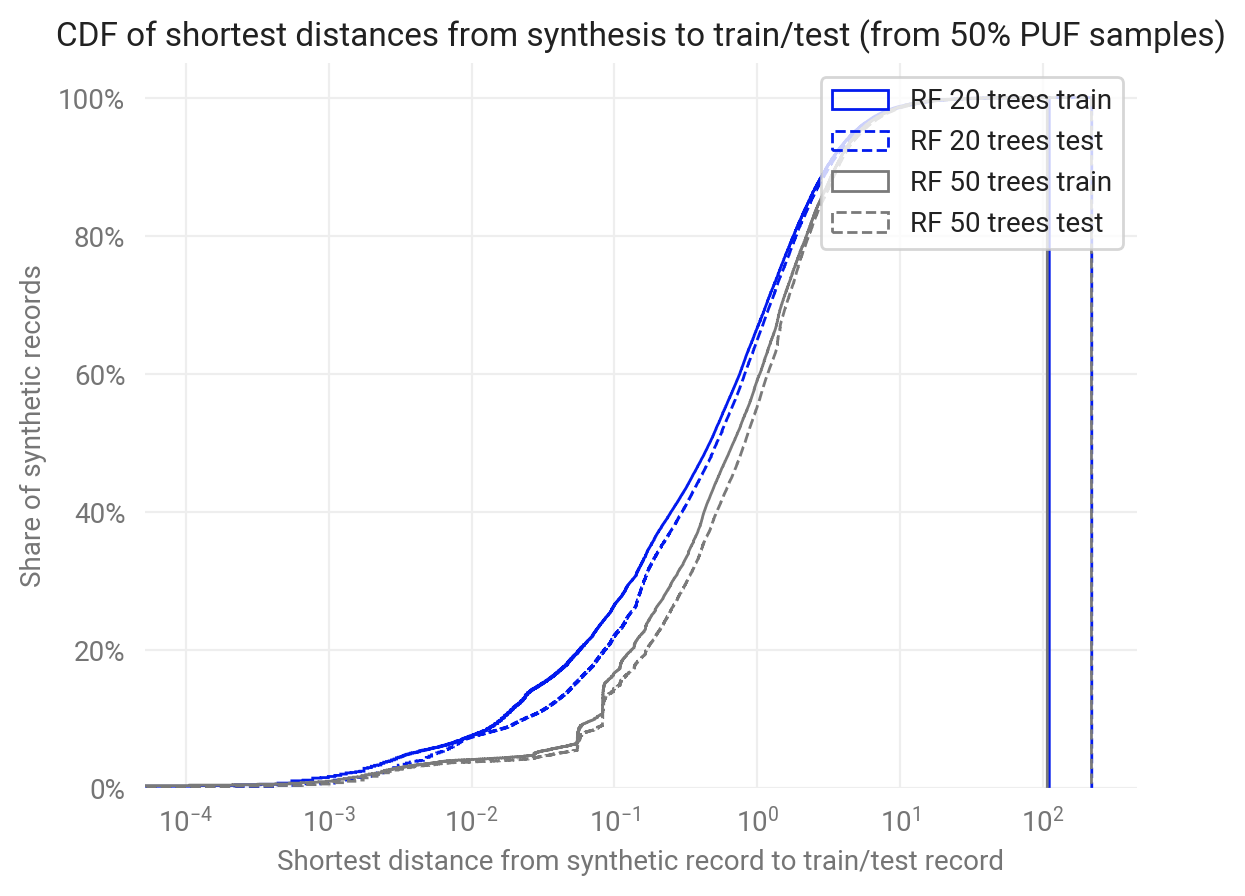

In [18]:
# Plot the four series.
BINS = 1000000
ax = nearest1.train_dist.hist(cumulative=True, density=1, bins=BINS, color='#021aee', histtype='step')
nearest1.test_dist.hist(cumulative=True, density=1, bins=BINS, histtype='step', color='#021aee', ls='--')
nearest2.train_dist.hist(cumulative=True, density=1, bins=BINS, histtype='step', color='#7a7a7a')
nearest2.test_dist.hist(cumulative=True, density=1, bins=BINS, histtype='step', color='#7a7a7a', ls='--')
# Formatting.
ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(
    lambda y, _: '{:.0%}'.format(y)))
ax.grid(color='#eeeeee')
sns.despine(left=True, bottom=True)
plt.xscale('log')
plt.legend([NAME1 + ' train', NAME1 + ' test', NAME2 + ' train', NAME2 + ' test'])
ax.set(xlabel='Shortest distance from synthetic record to train/test record',
       ylabel='Share of synthetic records')
plt.title('CDF of shortest distances from synthesis to train/test (from 50% PUF samples)')
plt.show()

### Ratio of train/test median distances

In [19]:
print(NAME1)
nearest1.train_dist.median() / nearest1.test_dist.median()

RF 20 trees


0.8932657872536154

In [20]:
print(NAME2)
nearest2.train_dist.median() / nearest2.test_dist.median()

RF 50 trees


0.8300826989980926

In [31]:
nearest1.dist_ratio.median()

0.9850969431289184

In [32]:
nearest2.dist_ratio.median()

0.9859985323703804

### Exact matches

In [21]:
exact_matches = pd.DataFrame({
    'type': ['train', 'train', 'test', 'test'],
    'model': [NAME1, NAME2, NAME1, NAME2],
    'share_exact': [(nearest1.train_dist == 0).mean(),
                    (nearest2.train_dist == 0).mean(),
                    (nearest1.test_dist == 0).mean(),
                    (nearest2.test_dist == 0).mean()]})
exact_matches

,type,model,share_exact
0,train,RF 20 trees,0.000696
1,train,RF 50 trees,0.000769
2,test,RF 20 trees,0.000049
3,test,RF 50 trees,0.000024


In [22]:
exact_matches_bool = pd.DataFrame({
    'type': 'train',
    'model': NAME1,
    'share_exact': (nearest1.train_dist == 0)
}).append(pd.DataFrame({
    'type': 'test',
    'model': NAME1,
    'share_exact': (nearest1.test_dist == 0)
})).append(pd.DataFrame({
    'type': 'train',
    'model': NAME2,
    'share_exact': (nearest2.train_dist == 0)
})).append(pd.DataFrame({
    'type': 'test',
    'model': NAME2,
    'share_exact': (nearest2.test_dist == 0)
}))

/home/maxghenis/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


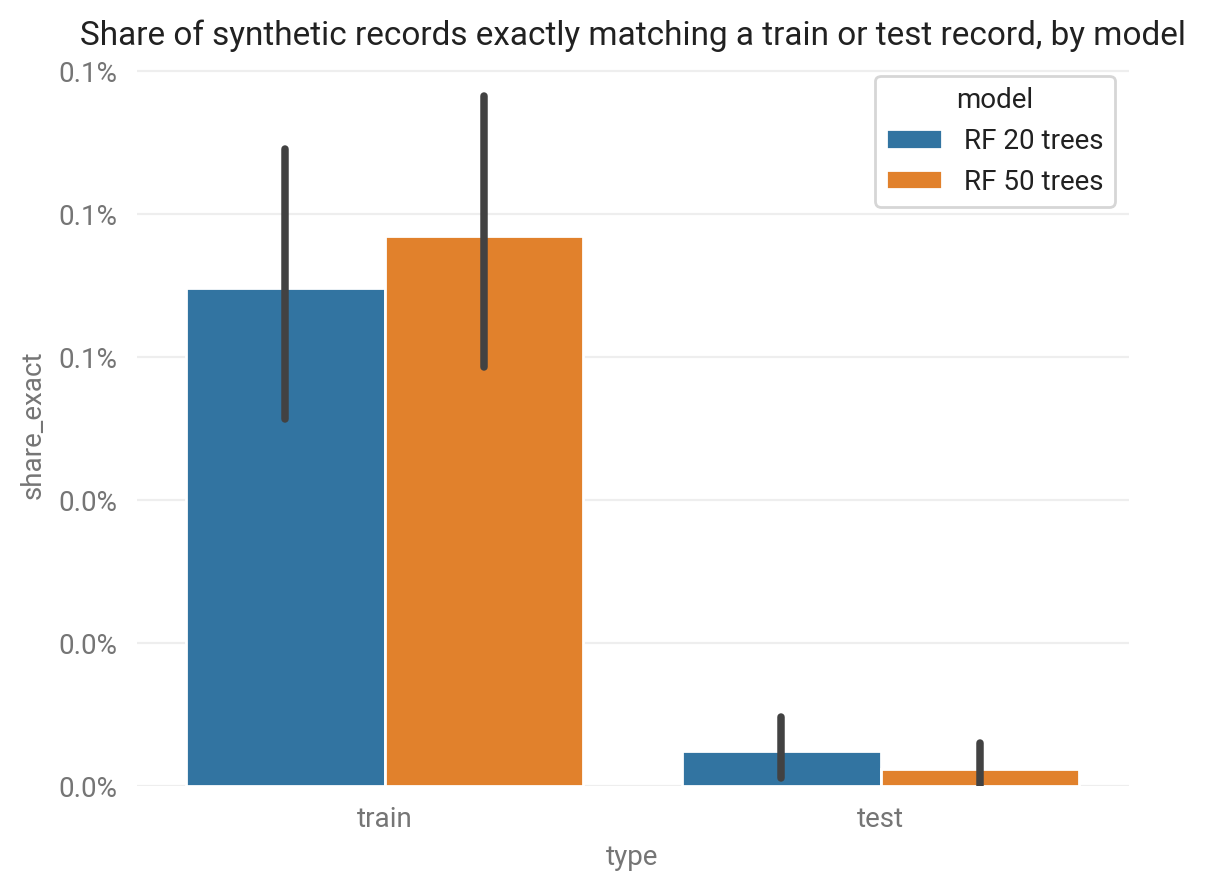

In [23]:
ax = sns.barplot(x='type', y='share_exact', hue='model', data=exact_matches_bool)
sns.despine(left=True, bottom=True)
ax.yaxis.grid(color='#eeeeee')
ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(
    lambda y, _: '{:.1%}'.format(y)))
plt.title('Share of synthetic records exactly matching a train or test record, by model')
plt.show()

What share of exact matches to train also exactly matched a test?

In [24]:
def share_exact_matches(df):
    exact_train = df[df.train_dist == 0]
    return((exact_train.test_dist == 0).sum() / exact_train.shape[0])

print(NAME1)
share_exact_matches(nearest1)

RF 20 trees


0.07017543859649122

In [25]:
print(NAME2)
share_exact_matches(nearest2)

RF 50 trees


0.031746031746031744

### Record complexity

Number of nonzero attributes.

In [26]:
synth1['nonzeros'] = synth1.astype(bool).sum(axis=1)

In [27]:
synth1.nonzeros.describe()

count    81893.000000
mean        16.693954
std          6.957372
min          3.000000
25%         11.000000
50%         16.000000
75%         22.000000
max         42.000000
Name: nonzeros, dtype: float64

### Identical records

In [28]:
def nonzero_rows(df):
    if isinstance(df, pd.Series):
        return df[df != 0]
    # If only one row, assume we're looking for nonzero columns.
    if df.shape[0] == 1:
        df = df.transpose()
    return df.loc[(df!=0).any(axis=1)]